### Names
Ragger Jonkers (10542604)<br>
Joeri Sleegers (10631186)<br>
Eelco van der Wel (10670033)

### Theoretical part

1)a P(mth experiment gives significant result | m experiments lacking power to reject H0) = $$\alpha (1-\alpha)^{m-1}$$ <br>
1)b P(at least one significant result | m experiments lacking power to reject H0) = $$\displaystyle \sum_{i=1}^m \alpha (1-\alpha)^{i-1}$$

2)

| A  | *B*  |
|----|--------|
| d1 | *d3* |
| d2 | *d1* |
| d3 | *d2* |

| I|
|--------|
| d1 |
| *d3*     |
|*d2*|

| I|
|--------|
| d1 |
| *d3*     |
|d2|

| I|
|--------|
| *d3* |
| d1     |
|d2|

| I|
|--------|
| *d3* |
| d1     |
|*d2*|

Above you can see a document ranking of system A and B(bold). There are four possible team-draft interleavings. Consider the user only clicks on the 3rd rank, so that only document 2 can be considered relevant. As we can see, A and B both win 50% of the time, while system A has document 2 ranked higher. This proposes unfairness to system A. A should outperform B

### Experimental part

### Step 1
Simulate Rankings of Relevance for E and P

In [245]:
import math
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
def pair_generator():
    """
    A generator that returns pairs of all possible combinations 
    of [N, R, HR] of length 5."""
    for p in itertools.product(itertools.product(['N', 'R', 'HR'], repeat=5), repeat=2):
        yield p

def random_sample(length):
    '''
    Returns a sample pair that
    consists of a production and 
    an experiment list, with as possible
    values {N, R, HR}.
    '''
    values = ['N', 'R', 'HR']
    
    p = [values[random.randint(0, 2)] for _ in range(length)]
    e = [values[random.randint(0, 2)] for _ in range(length)]
    
    return p, e

print('Total number of pairs:', len(list(pair_generator())))
print('first 10 pairs:')
pair_gen = pair_generator()
for _ in range(10):
    print(next(pair_gen))

Total number of pairs: 59049
first 10 pairs:
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'N', 'N'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'N', 'R'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'N', 'HR'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'R', 'N'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'R', 'R'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'R', 'HR'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'HR', 'N'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'HR', 'R'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'N', 'HR', 'HR'))
(('N', 'N', 'N', 'N', 'N'), ('N', 'N', 'R', 'N', 'N'))


### Step 2
Implement Evaluation Measures. <br>
Used measures: binary precision, ndcg, err

In [3]:
def binary_precision(documents, **kwargs):
    """
    Returns the binary precision for a list of documents, which is the amount
    of documents which where some form of relevant or !not relevant.
    
    Arguments:
    documents -- list of document relevances
    """
    return np.array([0 if d == 'N' else 1 for d in documents]).sum() / len(documents)

def normalized_discounted_cumulative_gain(documents, **kwargs):
    """
    Returns ndcg score of a list of documents, as decribed in http://doi.acm.org/10.1145/1645953.1646033.
    
    Arguments:
    documents     -- list of document relevances
    relevance_map -- dictionary that maps relevance to score
    """
    dcg = np.array([
        (2 ** kwargs['relevance_map'][relevance] - 1) / np.log2(rank + 1)
        for rank, relevance in enumerate(documents, start=1) 
    ])
    return (dcg / (max(kwargs['relevance_map'].values()) * len(documents))).sum() if dcg.max() != 0 else 0

def expected_reciprocal_rank(documents, **kwargs):
    """ 
    Returns expected reciprocal rank score for list of documents, as decribed in 
    http://doi.acm.org/10.1145/1645953.1646033.
    
    Arguments:
    documents     -- list of document relevances
    relevance_map -- dictionary that maps relevance to score
    """
    P = 1
    E = 0
    for rank, relevance in enumerate(documents, start=1):
        R = (2 ** kwargs['relevance_map'][relevance] - 1) / (2 ** max(kwargs['relevance_map'].values()))
        E += P * R / rank
        P *= (1-R)
    return E

In [4]:
# Test each implemented measure on a sample datapoint

production, experimental = random_sample(5)

relevance_map = {
    'N': 0,
    'R': 1,
    'HR': 2
}

print('Precision of production algorithm:\t', binary_precision(documents=production))
print('Precision of experimental algorithm:\t', binary_precision(documents=experimental))

print('EER of production algorithm:\t\t', expected_reciprocal_rank(
    documents=production, relevance_map=relevance_map))
print('EER of experimental algorithm:\t\t', expected_reciprocal_rank(
    documents=experimental, relevance_map=relevance_map))

print('NDCG of production algorithm:\t\t', normalized_discounted_cumulative_gain(
    documents=production, relevance_map=relevance_map))
print('NDCG of experimental algorithm:\t\t', normalized_discounted_cumulative_gain(
    documents=experimental, relevance_map=relevance_map))

Precision of production algorithm:	 0.4
Precision of experimental algorithm:	 0.2
EER of production algorithm:		 0.3125
EER of experimental algorithm:		 0.375
NDCG of production algorithm:		 0.15
NDCG of experimental algorithm:		 0.189278926071


### Step 3
For the three measures and all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P.

Delta measures are calculated on 5000 random datapoints

In [177]:
def delta(data, eval_function, relevance_map):
    """
    Returns list of document pairs in data with there corresponding 
    difference of performance per pair calculated with eval_function.
    
    Arguments:
    data          -- list of documents pairs containing relevance labels
    eval_function -- evaluation function to score performance of list
                     of relevance labels
    relevance_map -- dictionary that contains mapping from relevance 
                     label to score
    """
    return [(docs1, docs2, 
             eval_function(docs2, relevance_map=relevance_map) -
             eval_function(docs1, relevance_map=relevance_map))
            for docs1, docs2 in data]

# Generate 5000 random datapoints
sampled_data = [random_sample(5) for _ in range(5000)]

# select pairs where Experimental algorithm outperforms Production algorithm
data_ndcg = [x for x in delta(sampled_data, normalized_discounted_cumulative_gain, relevance_map) if x[2] > 0]
print('Average of ndcg delta for each pair where E outperforms P\t\t', 
      sum([x[2] for x in data_ndcg]) / len(data_ndcg))

data_err = [x for x in delta(sampled_data, expected_reciprocal_rank, relevance_map) if x[2] > 0]
print('Average of err delta for each pair where E outperforms P\t\t', 
      sum([x[2] for x in data_err]) / len(data_err))

data_bp = [x for x in delta(sampled_data, binary_precision, relevance_map) if x[2] > 0]
print('Average of binary_precision delta for each pair where E outperforms P\t', 
      sum([x[2] for x in data_bp]) / len(data_bp))

Average of ndcg delta for each pair where E outperforms P		 0.204912781544
Average of err delta for each pair where E outperforms P		 0.2680035780826557
Average of binary_precision delta for each pair where E outperforms P	 0.310215053763


### Step 4
Implement Team-Draft interleaving and Balanced interleaving

In [271]:
def teamdraft_interleaving(docs1, docs2):
    """
    Returns interleaved list of documents from docs1 and docs2 based on teamdraft
    interleaving as well as a list where the indices refer to the set the document
    originally cam from. 
    based on http://www.cs.cornell.edu/people/tj/publications/chapelle_etal_12a.pdf  
    
    Arguments:
    docs1 -- list of documents
    docs2 -- list of documents
    """
    team_a = set()
    team_b = set()
    I = []
    pointers = []
    
    while len(set(docs1) - set(I)) > 0 and len(set(docs2) - set(I)):
        if len(team_a) < len(team_b) or (len(team_a) == len(team_b) and random.random() > 0.5):
            k = [x for x in docs1 if not x in I][0]
            I.append(k)
            team_a.add(k)
            pointers.append('A')
        else:
            k = [x for x in docs2 if not x in I][0]
            I.append(k)
            team_b.add(k)
            pointers.append('B')
    return I, pointers

def score_teamdraft_interleaving(a, b, I, pointers, clicks):
    """
    Returns the winner of interleaved set I based on clicks.
    returns A if team A has the most clicks, B if team B has the most clicks
    and T if it is a draw 
    
    Arguments:
    a --
    b --
    I        -- Interleaved set of documents
    pointers -- List of strings which represents origin of documents
    clicks   -- Binary list indicating wether a user cliced on a document of not
    """
    score = sum([1 if pointers[index[0]] == 'A' else -1 for index in np.argwhere(clicks==1)])
    return 'T' if score == 0 else 'A' if score > 0 else 'B'

def index_ranking_pair(docs1, docs2):
    """
    Turn a pair (docs1, docs2) of rankings to pair of indices [[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]].
    Returns indiced pairs and mapping between indices and rankings.
    
    Arguments:
    docs1 -- list of relevance labels of documents
    docs2 -- list of relevance labels of documents
    """
    generated_docs1 = [x for x in range(len(docs1))]
    generated_docs2 = [x + len(p) for x in range(len(docs2))]
    mapping = docs1 + docs2
    return generated_docs1, generated_docs2, mapping

docs1, docs2 = random_sample(5)
gen_docs1, gen_docs2, mapping = index_ranking_pair(p, e)

I, pointers = teamdraft_interleaving(p_n, e_n)
labels_i = [mapping[i] for i in I]

print('Single sample with Team-Draft Interleaving:')
print('Labels converted to unique documents\t\t', gen_docs1, gen_docs2)
print('Set of interleaved documents\t\t\t', I)
print('Original labels of interleaved documents\t', labels_i)

Single sample with Team-Draft Interleaving:
Labels converted to unique documents		 [0, 1, 2, 3, 4] [5, 6, 7, 8, 9]
Set of interleaved documents			 [0, 5, 6, 1, 2, 7, 3, 8, 9]
Original labels of interleaved documents	 ['R', 'HR', 'R', 'N', 'N', 'R', 'HR', 'HR', 'R']


In [272]:
def balanced_interleaving(docs1, docs2):
    """
    Returns interleaved list of docs1 and docs2 using balanced interleaving.
    based on http://www.cs.cornell.edu/people/tj/publications/chapelle_etal_12a.pdf 
    
    Arguments:
    docs1 -- list of documents
    docs2 -- list of documents
    """
    I = []
    k_a = 0
    k_b = 0
    first = random.randint(0, 1) # 0 or 1
       
    while((k_a < len(docs1)) and (k_b < len(docs2))):
        if k_a < k_b or k_a == k_b and first:
            if docs1[k_a] not in I:
                I.append(docs1[k_a])
            k_a += 1
        else:
            if docs2[k_b] not in I:
                I.append(docs2[k_b])
            k_b += 1
            
    return np.array(I), None
        
def score_balanced_interleaving(docs1, docs2, I, pointers, clicks):
    '''
    Return the winner of algorithm A and B or T if it is draw.
    given the interleaved list I and the clicks of the user on that list.
    
    Arguments:
    docs1   -- list of documents
    docs2   -- list of documents
    I       -- interleaving of docs1 and docs2
    pointer -- backpointers to where the docs in I came from
    clicks  -- binary array of wether a user clicked on the document
    '''
    score_A = 0
    score_B = 0
    clicked_items = ([I[i[0]] for i in np.argwhere(clicks==1)])
    if any(clicked_items): # User has at least one click
        playfield = highest_index(clicked_items[-1], docs1, docs2) + 1  
    else:
        return 'T' # return Tie
    A_reduced = docs1[:playfield]
    B_reduced = docs2[:playfield]

    for item in clicked_items:
        if item in A_reduced:
            score_A += 1
        if item in B_reduced:
            score_B += 1

    if score_A > score_B:
        return 'A'
    elif score_B > score_A:
        return 'B'
    else:
        return 'T' 

def highest_index(item, docs1, docs2):
    """
    Determine the line above which the items 
    of each set count towards the to be calculated score   
    
    Arguments:
    item  -- clicked document
    docs1 -- list of documents
    docs2 -- list of documents
    """
    for index, _ in enumerate(A):
        if item == docs1[index] or item == docs2[index]:
            return index

### Step 5
Implement User Clicks Simulation

In [8]:
# To estimate clickmdel parameters, the provided Yandex file is used

def load_yandex(filename):
    """
    Extract clicks from a given yandex file. Return a binary matrix where each row is a session,
    and a 1 at position [i, j] represents a click in session i on document j.
    
    Arguments
    filename   -- name of the yandex file.
    """
    sessions = []
    
    with open(filename, 'r') as f:
        data = [line.strip().split('\t') for  line in f.readlines()]
    for i, query_line in enumerate(data):
        # Q indicates start of a session
        if query_line[2] == "Q":
            url_ids = query_line[5:]
            
            # Get url_ids of all subsequent lines that are clicks
            clicks = np.zeros(len(url_ids))
            for click_line in data[i+1:]:
                if click_line[2] == "C":
                    click_url = click_line[3]
                    if click_url not in url_ids:
                        continue
                    clicks[url_ids.index(click_url)] = 1
                else:
                    break

            sessions.append(clicks)
    return np.vstack(sessions)

print('Loading sessions from Yandex file...')
sessions = load_yandex('YandexRelPredChallenge.txt')
print('Number of sessions:', len(sessions))

Loading sessions from Yandex file...
Number of sessions: 42652


In [114]:
# Implement PBM and RCM

def calc_alpha(label):
    return 2 ** relevance_map[label] / 2 ** max(relevance_map.values())


class PBM(object):
    def __init__(self, ranking_size):
        self.alpha = defaultdict(lambda: 1)
        self.gamma = [random.random() for _ in range(ranking_size)]
        
    def estimate(self, S):
        """Estimate parameters of the model."""
        self.gamma = S.sum(axis=0) / len(S)
    
    def predict(self, ranking):
        """Predict click probabilities of a given session."""
        return [g * calc_alpha(u) for g, u in zip(self.gamma, ranking)]
           
    def simulate(self, ranking):
        """Simulate clicks on a given session."""
        probs = self.predict(ranking)
        return np.array([1 if np.random.random() < prob else 0 for prob in probs])

class RCM:
    def _init_(self):
        self.rho = 0
        
    def estimate(self, S):
        """Estimate parameters of the model."""
        self.rho = np.sum(S) / S.size
        
    def predict(self, ranking):
        """Predict click probabilities of a given session."""
        probs = [self.rho] * len(ranking)
        return probs
            
    def simulate(self, ranking):
        """Simulate clicks on a given session."""
        return np.array([1 if np.random.random() < prob else 0 for prob in self.predict(ranking)])

print('RCM parameters')
rcm_model = RCM()
rcm_model.estimate(sessions)
print('rho =', rcm_model.rho)
print()

print('PBM parameters')
pbm_model = PBM(sessions.shape[1])
pbm_model.estimate(sessions)
print('gamma =', pbm_model.gamma)

RCM parameters
rho = 0.125025790115

PBM parameters
gamma = [ 0.45006096  0.1950905   0.13931351  0.10569258  0.08184845  0.06712464
  0.05936416  0.05296352  0.04808684  0.05071275]


In [178]:
def simulate_interleaving(data, N, clickmodel, interleaver, interleave_scorer):
    win_rates = []
    lose_rates = []
    tie_rates = []
    
    for A, B, _ in data:
        winners = []
        
        # Convert A and B to pages with unique indices for interleaving
        a_n, b_n, mapping = index_ranking_pair(A, B)
        # Create interleaving of indexed pages
        I_n, pointers = interleaver(a_n, b_n)
        # Convert indices back to rankings
        I = [mapping[i] for i in I_n]
        
        # simulate clicks N times on interleaving
        for i in range(N):
            session = clickmodel.simulate(I)
            winners.append(interleave_scorer(a_n, b_n, I_n, pointers, session))     
        win_rates.append(winners.count('B') / N)
        lose_rates.append(winners.count('A') / N)
        tie_rates.append(winners.count('T') / N)
    return win_rates, lose_rates, tie_rates

### Step 7. Results and Analysis.



In order to get more detailed insights in the differences between offline and online evaluation, we compare delta measures and online winrates in gradations. The delta measures are binned in five bins, and for each bin the average winrate is calculated.

In theory, the binned evaluation should not matter for the RCM model. Clicks are random, so a higher deltameasure should not result in a higher winrate. On the other hand, the PBM clickmodel should have a higher winrate on higher delta measures, since the attractiveness parameter $\alpha$ is taken into account when simulating the clicks.

In total, four visualizations are shown: a bargraph for each clickmodel for each interleaving method.

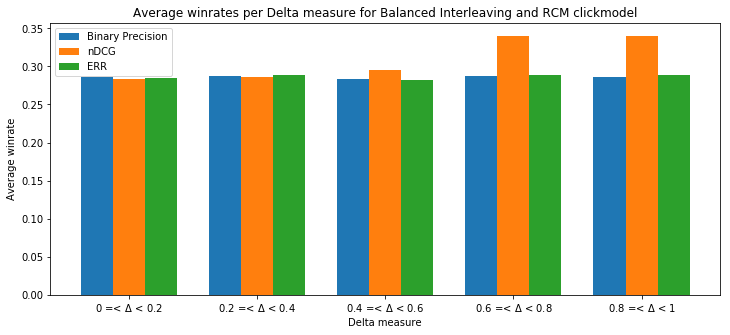

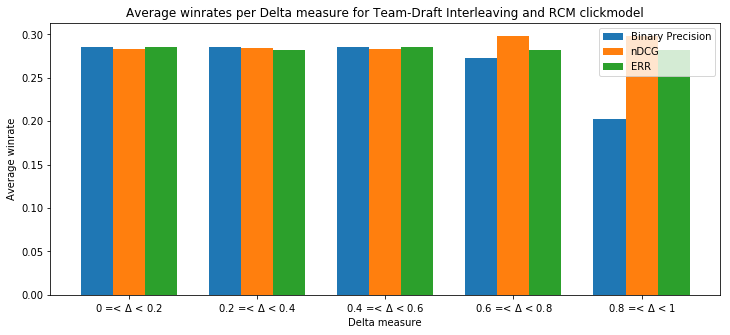

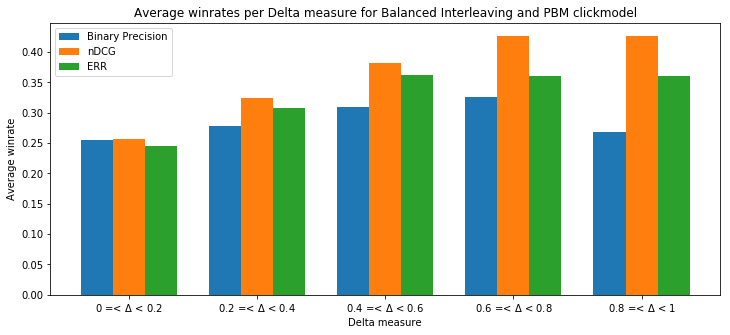

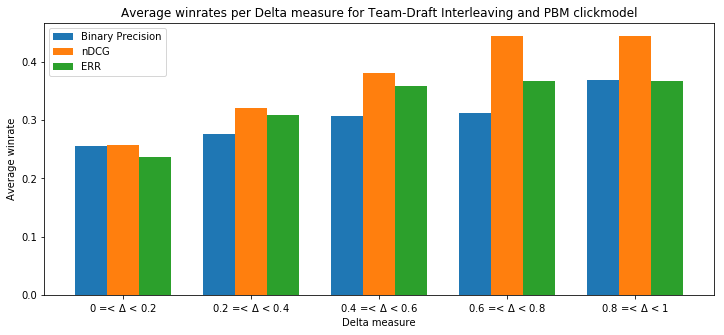

In [247]:
N = 300

# For fancy printing, register each measure, clickmodel and interleaver with name.
offline_measures = {'Binary Precision': data_bp,
                    'nDCG': data_ndcg,
                    'ERR': data_err}
click_models = {'RCM clickmodel': rcm_model,
                'PBM clickmodel': pbm_model}
interleavers = {'Balanced Interleaving': (balanced_interleaving, score_balanced_interleaving),
                'Team-Draft Interleaving': (teamdraft_interleaving, score_teamdraft_interleaving)}

simulations = {}

# For each clickmodel, for each interleaver, generate plot of 3 measurements
for clickmodel_name, click_model in click_models.items():
    for interleaver_name, (interleaver, scorer) in interleavers.items():
        plt.figure(figsize=(12, 5))
        for measure_idx, (measure_name, data) in enumerate(offline_measures.items()):
            # Simulate experiment for data belonging to measurement
            simulation = simulate_interleaving(data, N, click_model, interleaver, scorer)
            simulations[(clickmodel_name, interleaver_name, measure_name)] = simulation
            win_rates, lose_rates, tie_rates = simulation
            
            # Calculate bins
            measurements = [d[-1] for d in data]
            binned = np.digitize(measurements, np.linspace(0, 1, 5)[1:])
            
            # Calculate average winrate per bin
            avg_winrates = []
            for i in range(5):
                if len(np.argwhere(binned==i)):
                    bin_avg_winrate = np.sum(np.array(win_rates)[np.argwhere(binned==i)]) / len(np.argwhere(binned==i))
                avg_winrates.append(bin_avg_winrate)
                
            # Generate plot
            bar_offset = measure_idx * 0.25
            plt.bar(np.arange(5)+bar_offset, avg_winrates, width = 0.25, label=measure_name)
            plt.legend()
            plt.title('Average winrates per Delta measure for {} and {}'.format(interleaver_name, clickmodel_name))
            plt.xlabel('Delta measure')
            plt.xticks(np.arange(5)+0.25, ('0 =< $\Delta$ < 0.2', '0.2 =< $\Delta$ < 0.4', 
                                           '0.4 =< $\Delta$ < 0.6', '0.6 =< $\Delta$ < 0.8', '0.8 =< $\Delta$ < 1'))
            plt.ylabel('Average winrate')
        plt.show()

As expected, the measurements on the RCM clickmodels are the same, no matter the measured delta or the interleaving method. This is the correct behaviour, the clicks are random. In the next analysis we will only consider the PBM model. 


Next, the differences between the interleaving methods are compared. We use a t-test for this comparison.

In [268]:
# Get all simulations for Balanced interleaving and for Teamdraft interleaving

balanced_pbm_winrates = [simulations[('PBM clickmodel', 'Balanced Interleaving', m)][0] for m in offline_measures]
balanced_pbm_winrates = list(itertools.chain(*balanced_pbm_winrates))

teamdraft_pbm_winrates = [simulations[('PBM clickmodel', 'Team-Draft Interleaving', m)][0] for m in offline_measures]
teamdraft_pbm_winrates = list(itertools.chain(*teamdraft_pbm_winrates))

In [269]:
# Calculate statistics

print('mean/std winrate Balanced Interleaving: {:.4f}/{:.4f}'.format(
    np.mean(balanced_pbm_winrates), np.std(balanced_pbm_winrates)))
print('meand/std winrate Team-Draft Interleaving: {:.4f}/{:.4f}'.format(
    np.mean(teamdraft_pbm_winrates), np.std(teamdraft_pbm_winrates)))

ttest_result = stats.ttest_rel(balanced_pbm_winrates, teamdraft_pbm_winrates)
print('p-value:', ttest_result.pvalue)

mean/std winrate Balanced Interleaving: 0.2794/0.1241
meand/std winrate Team-Draft Interleaving: 0.2770/0.1063
p-value: 0.161445376072


A p-value of 0.16 means that there is a significant difference between the distributions of Balanced Interleaving and Team-Draft Interleaving. The main difference is the measured standard deviation, which is higher in the case of Balanced Interleaving. We can conclude that, while the mean winrates are similar, because of a lower variance Team-Draft interleaving is less prone to outliers.